Importing

In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [2]:
df = pd.read_csv('/content/drive/My Drive/jigsaw-toxic-comment-classification-challenge/train.csv')

In [36]:
df.tail(100)
#it will look more interactive if you use google_data_table

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159471,fe5b78a6d22198c4,If some people are anti-catholic then their ju...,0,0,0,0,0,0
159472,fe6585aaa6182d28,You ignored him too,0,0,0,0,0,0
159473,fe77e59403ac395e,", as User:Dr.K wasn't saying it in the article",0,0,0,0,0,0
159474,fe7b1f2bd3756b0b,"LaserActive \n\nHi SchuminWeb, I am confused b...",0,0,0,0,0,0
159475,fe93b5e609f5cfdd,Lists of Islamic Jihads,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


Pre-Process

In [4]:
from tensorflow.keras.layers import TextVectorization

In [5]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [6]:
MAX_FEATURES = 200000

In [7]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [8]:
vectorizer.adapt(X.values)

In [9]:
vectorized_text = vectorizer(X.values)

In [10]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [11]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

Creating Models

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [13]:
model = Sequential()
# Create the embedding layer
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer
model.add(Dense(6, activation='sigmoid'))

In [14]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [17]:
history = model.fit(train, epochs=100, validation_data=val)

Epoch 1/10
6981/6981 [==============================] - 821s 118ms/step - loss: 0.0599 - val_loss: 0.0454
Epoch 2/10
6981/6981 [==============================] - 735s 105ms/step - loss: 0.0456 - val_loss: 0.0406
Epoch 3/10
6981/6981 [==============================] - 721s 103ms/step - loss: 0.0404 - val_loss: 0.0348
Epoch 4/10
6981/6981 [==============================] - 718s 103ms/step - loss: 0.0360 - val_loss: 0.0333
Epoch 5/10
6981/6981 [==============================] - 720s 103ms/step - loss: 0.0320 - val_loss: 0.0296
Epoch 6/10
6981/6981 [==============================] - 714s 102ms/step - loss: 0.0295 - val_loss: 0.0261
Epoch 7/10
6981/6981 [==============================] - 712s 102ms/step - loss: 0.0260 - val_loss: 0.0224
Epoch 8/10
6981/6981 [==============================] - 718s 103ms/step - loss: 0.0233 - val_loss: 0.0204
Epoch 9/10
6981/6981 [==============================] - 719s 103ms/step - loss: 0.0210 - val_loss: 0.0177
Epoch 10/10
6981/6981 [=======================

In [50]:
from matplotlib import pyplot as plt
import seaborn as sns

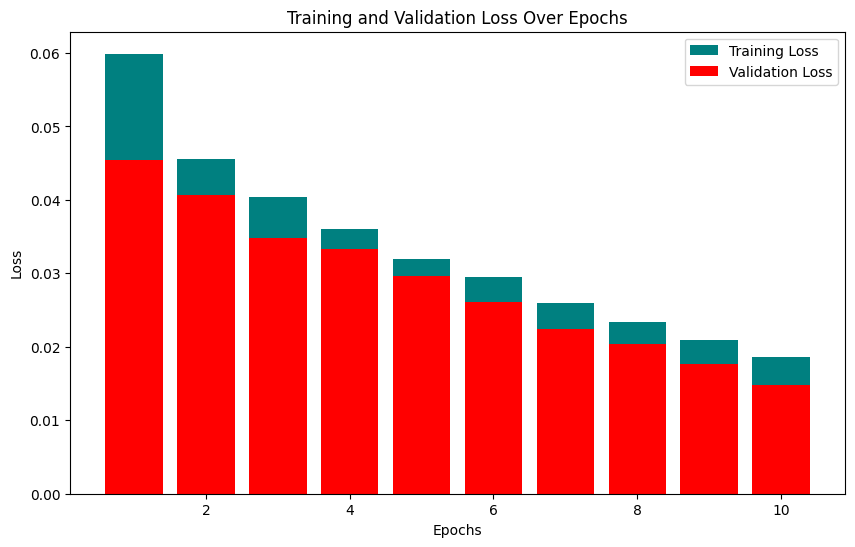

In [56]:
history_df = pd.DataFrame(history.history)
plt.figure(figsize=(10, 6))
epochs = range(1, len(history_df) + 1)
plt.bar(epochs, history_df['loss'], color='Teal', label='Training Loss')
plt.bar(epochs, history_df['val_loss'], color='Red', label='Validation Loss')

# Customize the plot
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
batch=test.as_numpy_iterator().next()

In [37]:
input_text = vectorizer('I will hit You!')

In [38]:
np.expand_dims(input_text,0)

array([[   8,   44, 1522, ...,    0,    0,    0]])

In [39]:
model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 0s 52ms/step


array([[0.4109379 , 0.00186049, 0.04367233, 0.2406891 , 0.10976613,
        0.02706579]], dtype=float32)

In [40]:
res = model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 0s 53ms/step


In [41]:
(res > 0.5).astype(int)

array([[0, 0, 0, 0, 0, 0]])

In [42]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [ ]:
(model.predict(batch_X) > 0.5).astype(int)

Evaluate

In [44]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [45]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
    # Unpack the batch
    X_true, y_true = batch
    # Make a prediction
    yhat = model.predict(X_true)

    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()

    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

In [57]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.914893627166748, Recall:0.9337281584739685, Accuracy:0.4714142382144928


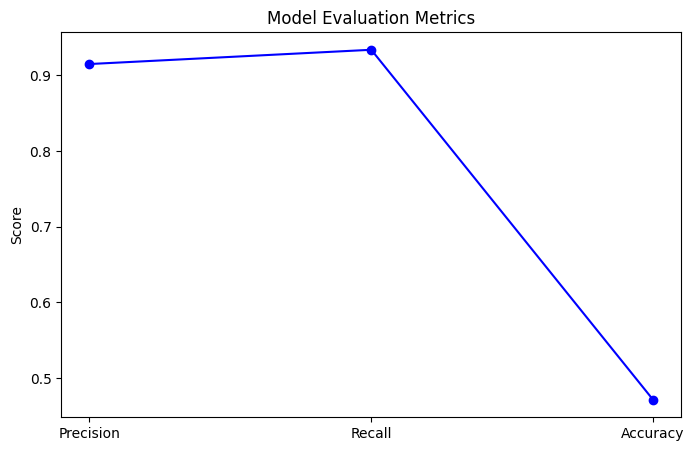

In [62]:
precision = pre.result().numpy()
recall = re.result().numpy()
accuracy = acc.result().numpy()

metrics = ['Precision', 'Recall', 'Accuracy']
values = [precision, recall, accuracy]

plt.figure(figsize=(8, 5))
plt.plot(metrics, values, marker='o', linestyle='-', color='blue')

plt.title('Model Evaluation Metrics')
plt.ylabel('Score')
plt.show()